In [1]:
import vit
from dataset import Yoga82
from utils import calculate_mean_std, get_train, get_test
from train import train
from eval import model_analysis
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader

In [2]:
# Settings
config = {
    "num_classes": 82,
    "img_size": 224,
    "img_channels": 3,
    "patch_size": 16,
    "hidden_size": 768,
    "hidden_dropout": 0.1,
    "attention_dropout": 0.1,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "mlp_hidden_size": 3072,
    "initializer_range": 0.02,
    "learning_rate": 3e-3,
    "betas": (0.9, 0.999),
    "weight_decay": 0.03,
    "batch_size": 20,
    "device": 'cuda',
    "epochs": 500,
    "hierarchy_level": 2,
    "transfer_learning": True,
}

In [3]:
# Get Train and Test image paths and respective labels for each hierarchy.
X_train, y_train_6, y_train_20, y_train_82 = get_train()
X_test, y_test_6, y_test_20, y_test_82 = get_test()

if config["hierarchy_level"] == 1:
    y_train = y_train_6
    y_test = y_test_6
    config["num_classes"] = 6
elif config["hierarchy_level"] == 2:
    y_train = y_train_20
    y_test = y_test_20
    config["num_classes"] = 20
elif config["hierarchy_level"] == 3:
    y_train = y_train_82
    y_test = y_test_82
    config["num_classes"] = 82

Train Dataset Total: 14976
Test Dataset Total: 5131


In [4]:
### DATASET PREPARATION ###

## Calculate mean and std per channel from X_train for Normalization.
# Takes a while, so save it after you do it so you don't have to compute it next time :3

# mean, std = calculate_mean_std(X_train)
mean = [0.6732, 0.6525, 0.6263]
std = [0.2339, 0.2360, 0.2378]

print("Mean:", mean)
print("Std:", std)

## Tranformations for Data Augmentation and Normalization

train_transforms = transforms.Compose([
    transforms.Resize((config["img_size"],config["img_size"]),antialias=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_transforms = transforms.Compose([
    transforms.Resize((config["img_size"],config["img_size"]),antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

## Generate Train and Test Datasets
# Takes about 5 minutes for me uwu
train_dataset = Yoga82(X_train, y_train, transform=train_transforms)
test_dataset = Yoga82(X_test, y_test, transform=test_transforms)

Mean: [0.6732, 0.6525, 0.6263]
Std: [0.2339, 0.236, 0.2378]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


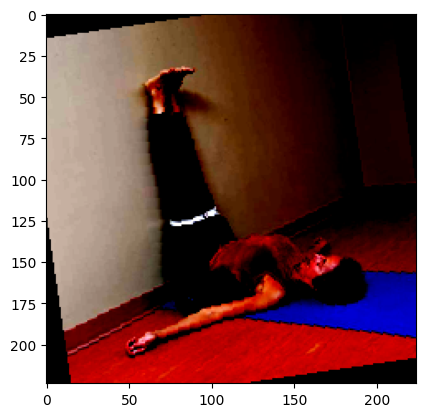

In [5]:
# Display an Image Example
import matplotlib.pyplot as plt
plt.imshow(train_dataset[7380][0].numpy().transpose(1,2,0))

In [6]:
# Create a Sampler to Balance Dataset
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR

class_weights = compute_class_weight('balanced', classes=range(max(y_train)+1), y=y_train)
class_weights = 1.0  /torch.tensor(class_weights, dtype=torch.float32)
sample_weights = class_weights[y_train]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

#Create model and training parameters
device = config["device"]
batch_size = config["batch_size"]
lr = config["learning_rate"]
betas = config["betas"]
weight_decay = config["weight_decay"]
model = vit.ViT(config).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.AdamW(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0.0001)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
# Load a pretrained State or Model
checkpoint = torch.load('ViT_B-16_Yoga6.pth')

#Remove Clasification MLP Weights and Bias for Transfer Learning
if config['transfer_learning']:
    checkpoint['model_state_dict'].pop('head.weight', None)
    checkpoint['model_state_dict'].pop('head.bias', None)

model.load_state_dict(checkpoint['model_state_dict'], strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])

In [8]:
train(model, train_dataloader, test_dataloader, optimizer, criterion, scheduler, config, run_name='head-20_backbone-6', init_epoch=0)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felipeandres-valenzuelar (pipper). Use `wandb login --relogin` to force relogin


Current Epoch: 1


  0%|          | 3/749 [00:01<05:29,  2.26it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 47%|████▋     | 355/749 [02:49<03:06,  2.11it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 749/749 [06:16<00:00,  1.99it/s]


Epoch 1 - Loss: 0.34021092029176503 - Model checkpoint saved to model_checkpoint_epoch_1.pth


100%|██████████| 257/257 [02:09<00:00,  1.98it/s]


Epoch 1 - Test Loss: 2.333300539955555
Current Epoch: 2


100%|██████████| 749/749 [06:33<00:00,  1.90it/s]


Epoch 2 - Loss: 0.14843772237222685 - Model checkpoint saved to model_checkpoint_epoch_2.pth


100%|██████████| 257/257 [02:08<00:00,  2.00it/s]


Epoch 2 - Test Loss: 2.5090674866962064
Current Epoch: 3


100%|██████████| 749/749 [06:34<00:00,  1.90it/s]


Epoch 3 - Loss: 0.12865258350866401 - Model checkpoint saved to model_checkpoint_epoch_3.pth


100%|██████████| 257/257 [02:14<00:00,  1.91it/s]


Epoch 3 - Test Loss: 2.625859291868915
Current Epoch: 4


  1%|          | 7/749 [00:04<08:03,  1.53it/s]


KeyboardInterrupt: 

In [9]:
# Load a pretrained State or Backbone

checkpoint = torch.load('model_checkpoint_epoch_1.pth')

model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

100%|██████████| 749/749 [06:37<00:00,  1.88it/s]



 Accuracy for Train Dataset: 0.9655448717948718


0.9655448717948718

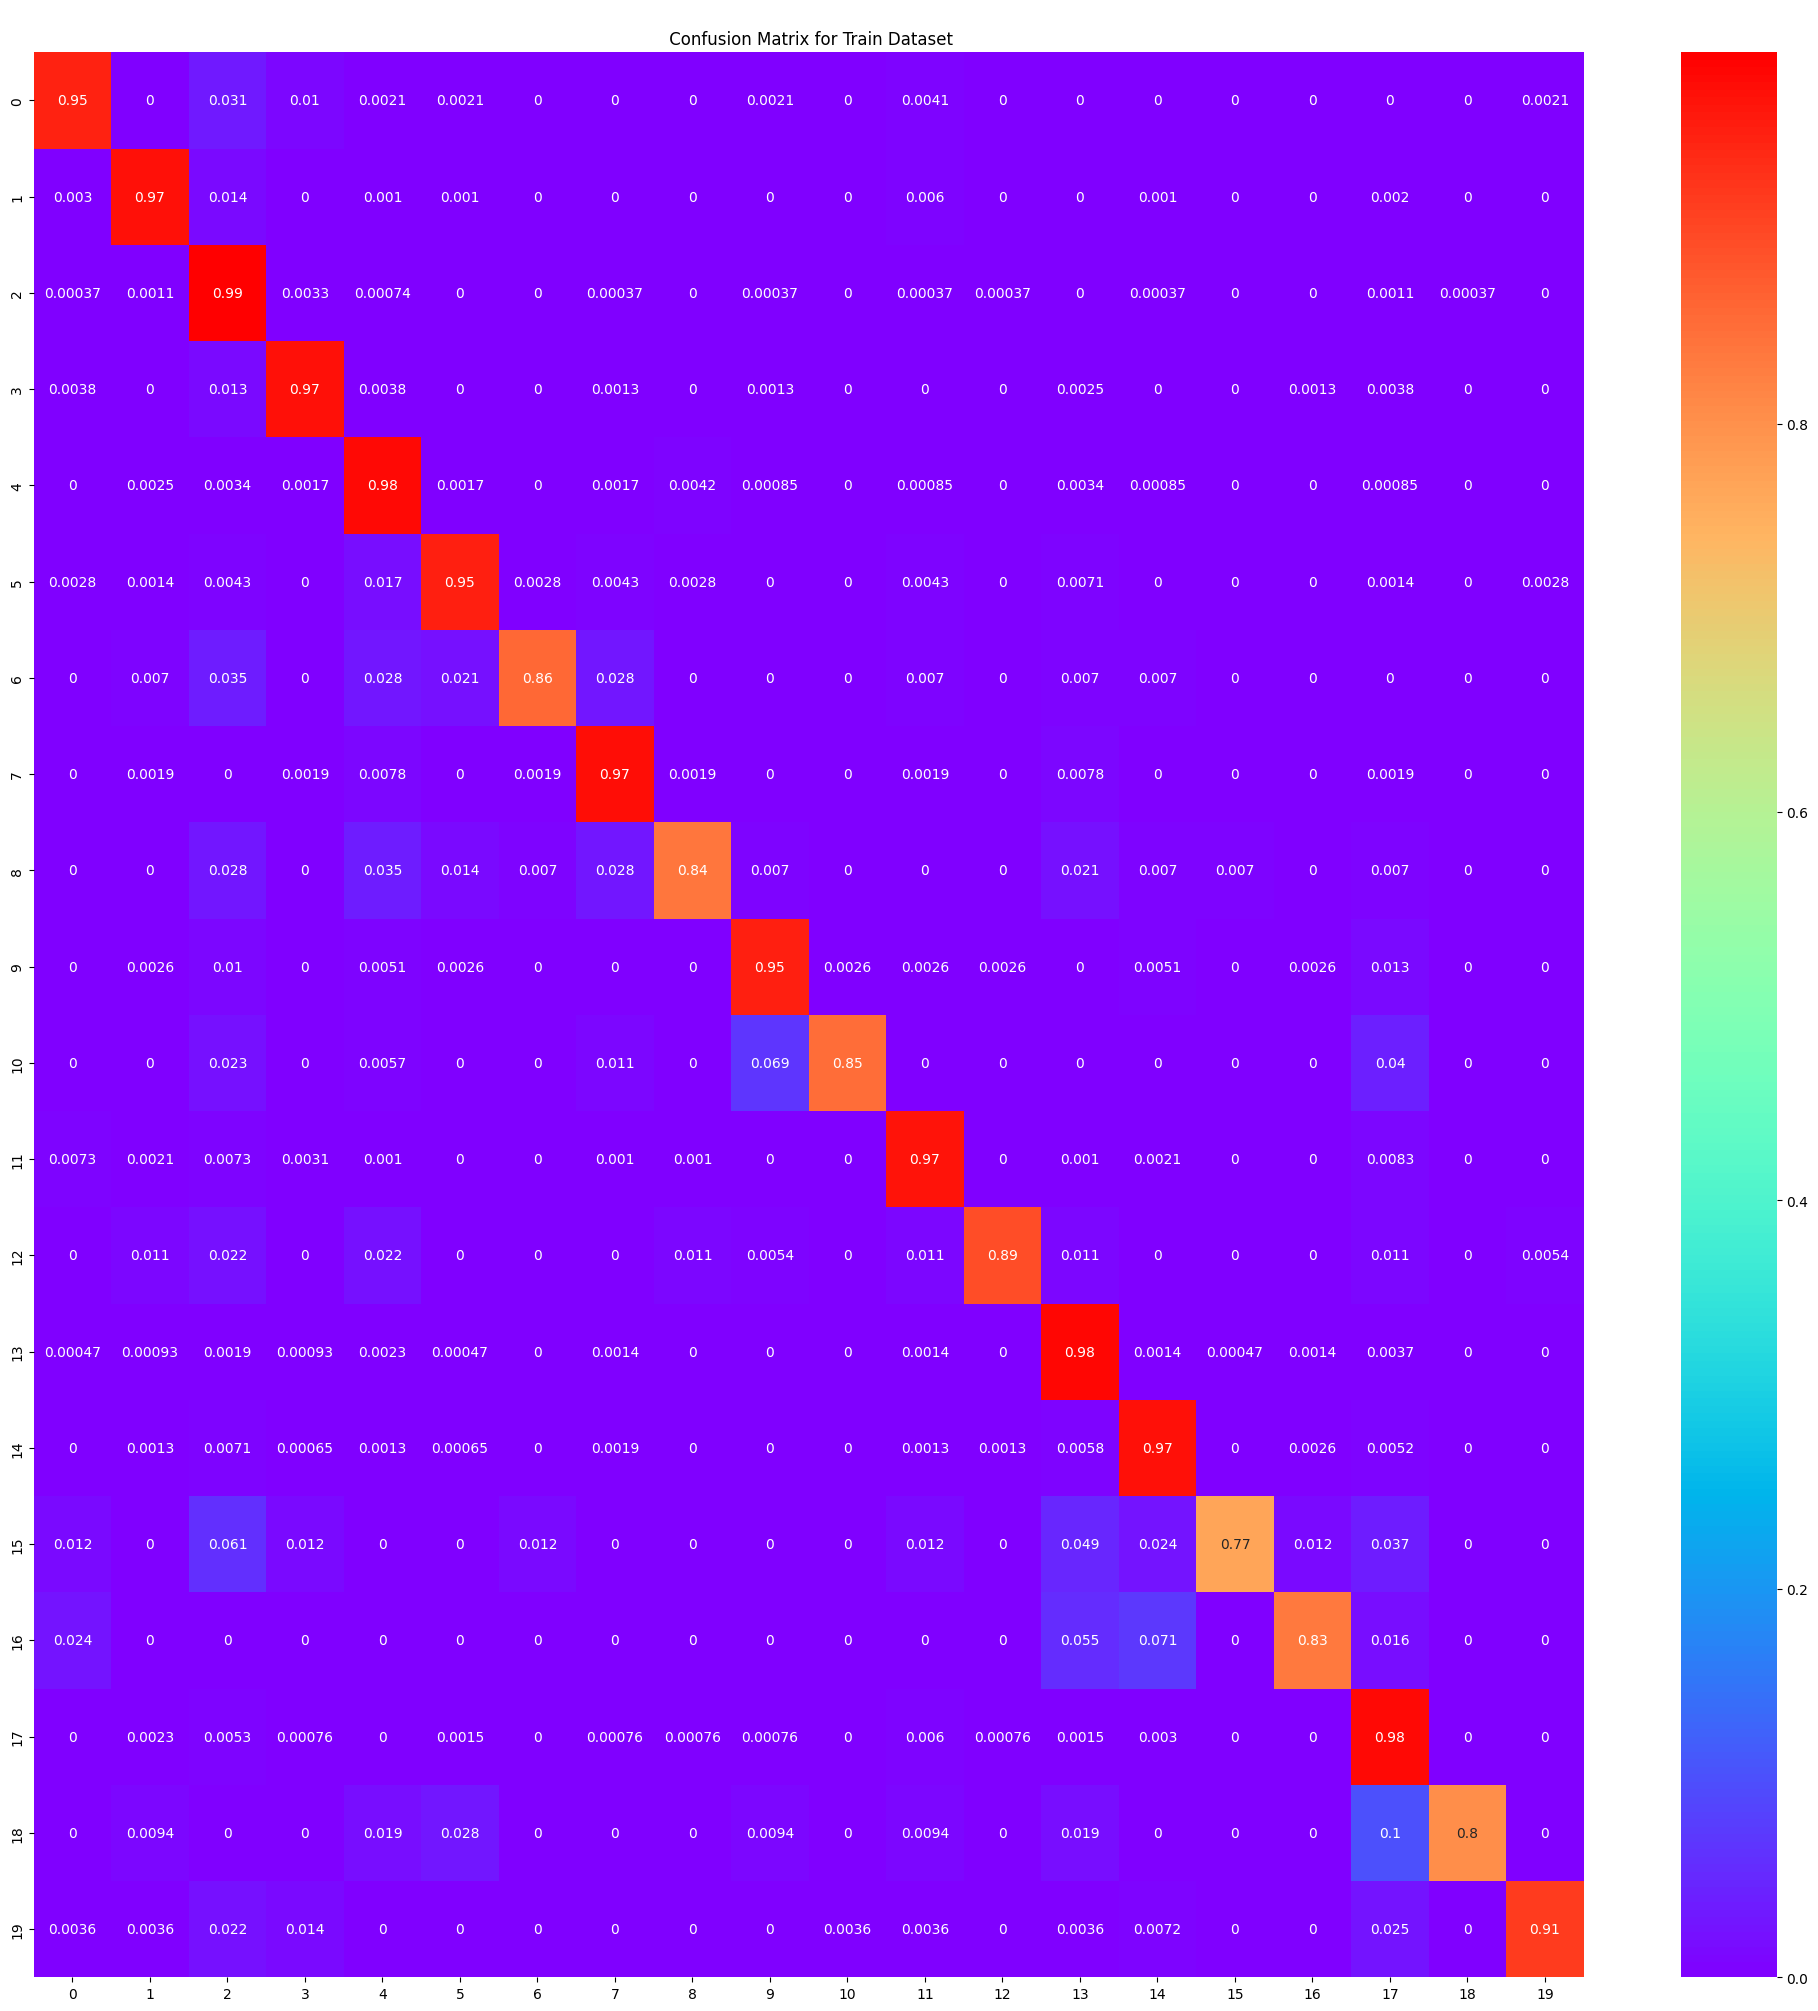

In [10]:
model_analysis(model, train_dataloader, dataset_name='Train Dataset')

  0%|          | 0/257 [00:00<?, ?it/s]

  3%|▎         | 7/257 [00:04<02:27,  1.69it/s]c:\Users\felip\anaconda3\envs\vit\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 257/257 [02:14<00:00,  1.91it/s]



 Accuracy for Test Dataset: 0.44494250633404797


0.44494250633404797

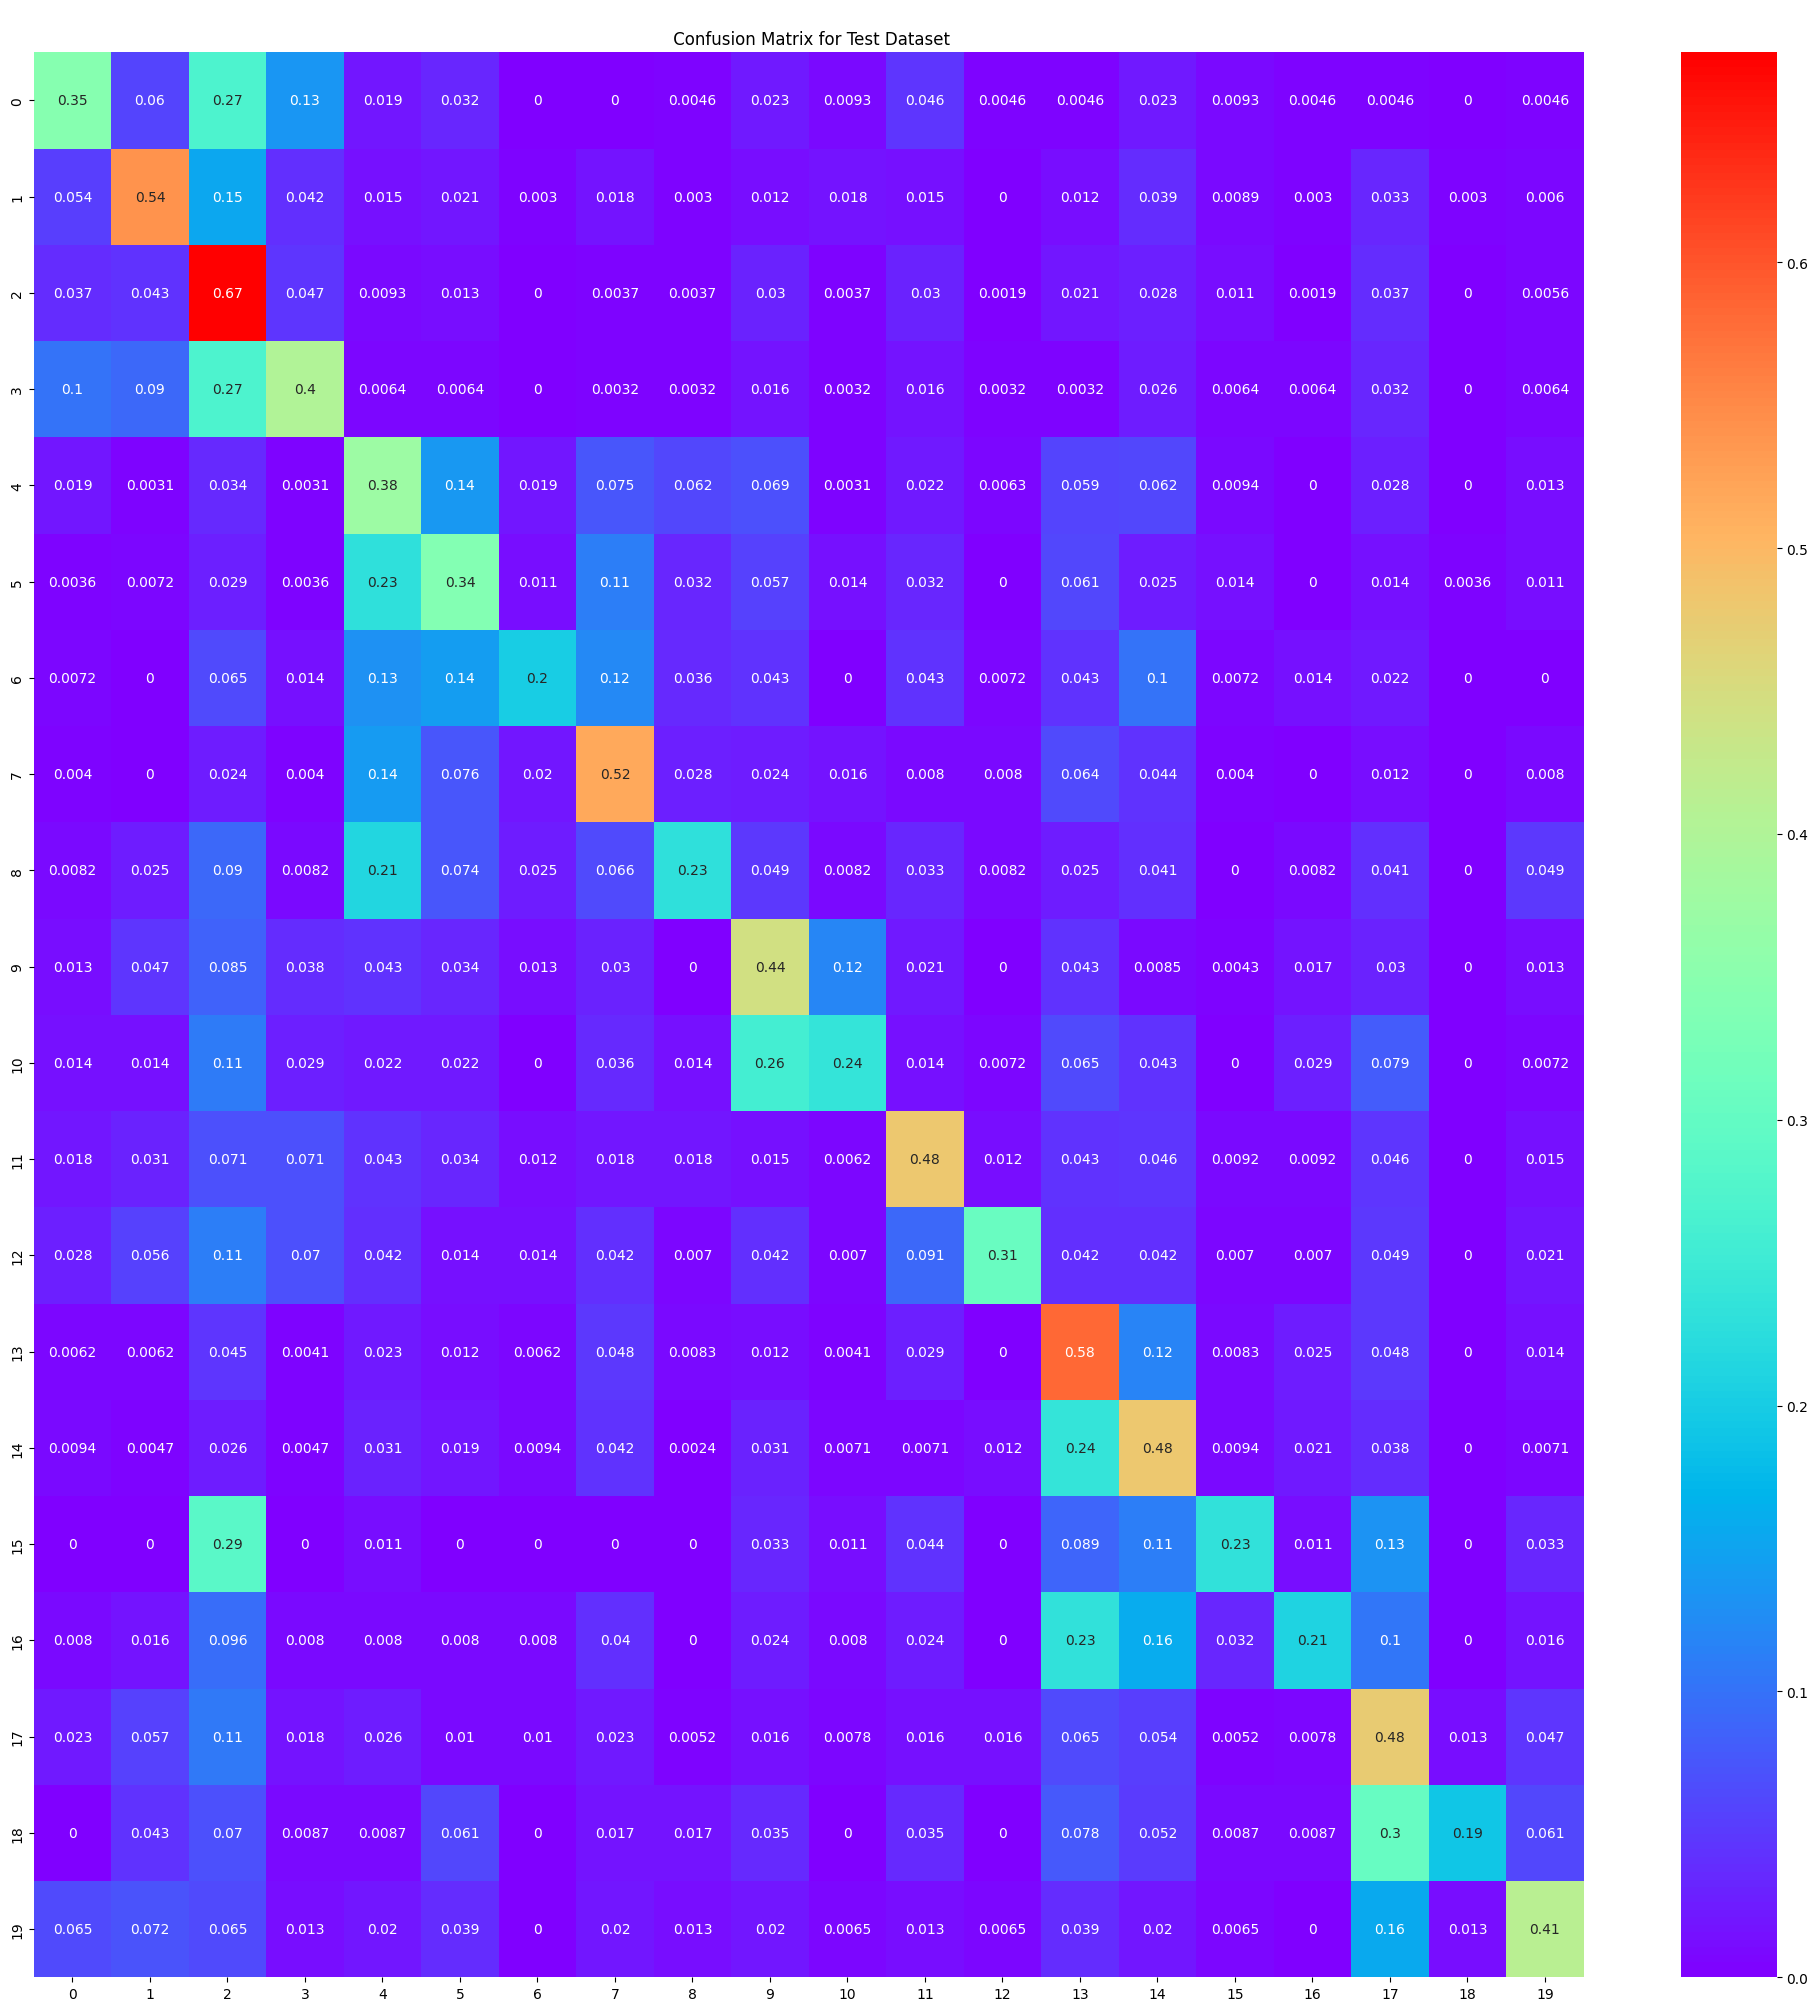

In [11]:
model_analysis(model, test_dataloader, dataset_name='Test Dataset')

In [12]:
checkpoint_path = f"ViT_B-16_Yoga20_Backbone6.pth"
torch.save({
            'epoch': 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
        }, checkpoint_path)